# Colab setup

In [ ]:
import sys
if "google.colab" in str(get_ipython()):
    ! {sys.executable} -m pip install pytorch-lifestream
    ! {sys.executable} -m pip install umap-learn
    ! {sys.executable} -m pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
 

# CoLES-demo-multimodal

**In this demo, we will try to show how Multimodal CoLES handles event data of different modalities.**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os

if not os.path.exists("lightning_logs/CoLES-demo-multimodal"):
    !mkdir -p lightning_logs/CoLES-demo-multimodal

if not os.path.exists("CatBoostClassifier"):
    !mkdir -p CatBoostClassifier

if not os.path.exists("model"):
    !mkdir -p model

# Libraries

In [ ]:
from functools import partial
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import umap

import torch
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from ptls.nn import TrxEncoder
from ptls.nn.seq_encoder.rnn_encoder import RnnEncoder
from ptls.frames import PtlsDataModule
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames.coles.multimodal_dataset import MultiModalDataset
from ptls.frames.coles.multimodal_dataset import MultiModalIterableDataset
from ptls.frames.coles.multimodal_dataset import MultiModalSortTimeSeqEncoderContainer
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceDataset
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceIterableDataset
from ptls.frames.inference_module import InferenceModuleMultimodal
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load import IterableProcessingDataset
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.datasets import MemoryMapDataset
from ptls.preprocessing import PandasDataPreprocessor

# Working with data

## Data load

In [ ]:
transactions = pd.read_csv("https://huggingface.co/datasets/dllllb/transactions-gender/resolve/main/transactions.csv.gz?download=true", compression="gzip")
targets = pd.read_csv("https://huggingface.co/datasets/dllllb/transactions-gender/resolve/main/gender_train.csv?download=true")

We will take one dataset (later we will explain why) of this type.

In [ ]:
transactions = transactions.dropna().reset_index(drop=True)
transactions

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,208 14:18:12,5499,1010,-7254.31,453799
1,39026145,208 14:24:23,5499,1010,-1392.47,453306
2,39026145,209 15:09:16,5499,1010,-2852.31,453306
3,39026145,209 15:13:51,5499,1010,-853.45,058435
4,39026145,209 15:13:17,5499,1010,-1410.44,058435
...,...,...,...,...,...,...
4084146,61870738,453 16:03:02,5499,1010,-5176.84,10217113
4084147,61870738,454 10:54:60,5411,1010,-1652.77,022915
4084148,61870738,454 14:23:59,5499,1010,-4687.23,10217113
4084149,61870738,454 16:11:53,5541,1110,-4491.83,RU570124


Here
1. `customer_id` is the id of some user
2. `tr_datetime` is the time of the transaction
3. `mcc_code` is, in fact, the mcc code of the transaction
4. `tr_type` is the type of transaction (what was paid for)
5. `amount` is the amount of the transaction
6. `term-id` is the id of the terminal where the transaction was carried out

We will predict the gender of the user based on his transactions.

In [ ]:
targets

,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1
...,...,...
8395,90417572,0
8396,66837341,0
8397,10758984,1
8398,11376556,0


In [ ]:
n_cutomers = len(pd.unique(transactions["customer_id"]))
n_labeling_cutomers = len(pd.unique(targets["customer_id"]))

print("n_cutomers:", n_cutomers)
print("n_labeling_cutomers:", n_labeling_cutomers)

n_cutomers: 14973
n_labeling_cutomers: 8400


As we can see, we do not know the gender of some users. But we don"t need it for CoLES-multimodal training! A little later, we will remove\
untagged users to train the classifier, and now we will train CoLES-multimodal on our data

## For example, we will make two "different" datasets from this dataset

In [ ]:
list(transactions.columns)

['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount', 'term_id']

**An important point.** \
Now we are splitting our dataset into two different ones. Let"s imagine for easier understanding that sourceA\
and sourceB represent different data modalities.

In [ ]:
sourceA = transactions[["customer_id", "tr_datetime", "mcc_code", "term_id"]]
sourceB = transactions[["customer_id", "tr_datetime", "tr_type", "amount"]]

In [ ]:
sourceA

,customer_id,tr_datetime,mcc_code,term_id
0,39026145,208 14:18:12,5499,453799
1,39026145,208 14:24:23,5499,453306
2,39026145,209 15:09:16,5499,453306
3,39026145,209 15:13:51,5499,058435
4,39026145,209 15:13:17,5499,058435
...,...,...,...,...
4084146,61870738,453 16:03:02,5499,10217113
4084147,61870738,454 10:54:60,5411,022915
4084148,61870738,454 14:23:59,5499,10217113
4084149,61870738,454 16:11:53,5541,RU570124


In [ ]:
sourceB

,customer_id,tr_datetime,tr_type,amount
0,39026145,208 14:18:12,1010,-7254.31
1,39026145,208 14:24:23,1010,-1392.47
2,39026145,209 15:09:16,1010,-2852.31
3,39026145,209 15:13:51,1010,-853.45
4,39026145,209 15:13:17,1010,-1410.44
...,...,...,...,...
4084146,61870738,453 16:03:02,1010,-5176.84
4084147,61870738,454 10:54:60,1010,-1652.77
4084148,61870738,454 14:23:59,1010,-4687.23
4084149,61870738,454 16:11:53,1110,-4491.83


Since we have too perfect a time match in each modality, we will remove random transactions from the first modality\
and random transactions from the second modality, after which we will already have a situation close to the real one.

In [ ]:
sourceA_drop_indices = np.random.choice(sourceA.index, 130000, replace=False)
sourceB_drop_indices = np.random.choice(sourceB.index, 420000, replace=False)

sourceA = sourceA.drop(sourceA_drop_indices).reset_index(drop=True)
sourceB = sourceB.drop(sourceB_drop_indices).reset_index(drop=True)

In [ ]:
sourceA

,customer_id,tr_datetime,mcc_code,term_id
0,39026145,208 14:18:12,5499,453799
1,39026145,209 15:09:16,5499,453306
2,39026145,209 15:13:51,5499,058435
3,39026145,209 15:13:17,5499,058435
4,39026145,210 00:00:00,5499,J139819
...,...,...,...,...
3954146,61870738,453 16:03:02,5499,10217113
3954147,61870738,454 10:54:60,5411,022915
3954148,61870738,454 14:23:59,5499,10217113
3954149,61870738,454 16:11:53,5541,RU570124


In [ ]:
sourceB

,customer_id,tr_datetime,tr_type,amount
0,39026145,208 14:18:12,1010,-7254.31
1,39026145,208 14:24:23,1010,-1392.47
2,39026145,209 15:09:16,1010,-2852.31
3,39026145,209 15:13:51,1010,-853.45
4,39026145,210 00:00:00,1110,-5277.90
...,...,...,...,...
3664146,61870738,452 19:33:04,1110,-4491.83
3664147,61870738,453 16:03:02,1010,-5176.84
3664148,61870738,454 14:23:59,1010,-4687.23
3664149,61870738,454 16:11:53,1110,-4491.83


Now we see that users in SourceA and users in sourceB have a different number of transactions. Moreover, it may\
have happened that some users are present in SourceA, but are absent from sourceB. Multimodal CoLES is able to\
process data with such gaps!

## Preprocessing

In [ ]:
mcc_code_in = len(np.unique((sourceA["mcc_code"])))
term_id_in = len(np.unique((sourceA["term_id"])))
tr_type_in = len(np.unique((sourceB["tr_type"])))

print("mcc_code_in:", mcc_code_in)
print("term_id_in:", term_id_in)
print("tr_type_in", tr_type_in)

mcc_code_in: 184
term_id_in: 435239
tr_type_in 72


### tr_datetime column preprocessing

To preprocess the tr_datetime column, we use our own function

In [ ]:
def tr_datetime_preprocess(tr_datetime):
    days, hms = tr_datetime.split()
    hh, mm, ss = hms.split(":")

    seconds = timedelta(hours=int(hh), minutes=int(mm), seconds=int(ss))
    seconds = seconds.total_seconds()
    seconds += int(days) * 24 * 3600

    return int(seconds)

In [ ]:
sourceA["tr_datetime"] = sourceA["tr_datetime"].apply(tr_datetime_preprocess)
sourceB["tr_datetime"] = sourceB["tr_datetime"].apply(tr_datetime_preprocess)

### Further preprocessing

Since we processed the tr_datetime column ourselves, we set the `event_time_transformation = "none"`.\
The other parameters are pretty clear.

In [ ]:
sourceA_preprocessor = PandasDataPreprocessor(
    col_id="customer_id",
    col_event_time="tr_datetime",
    event_time_transformation="none",
    cols_category=["mcc_code", "term_id"],
    return_records=False,
)

sourceB_preprocessor = PandasDataPreprocessor(
    col_id="customer_id",
    col_event_time="tr_datetime",
    event_time_transformation="none",
    cols_numerical=["tr_type", "amount"],
    return_records=False,
)

In [ ]:
processed_sourceA = sourceA_preprocessor.fit_transform(sourceA)
processed_sourceB = sourceB_preprocessor.fit_transform(sourceB)

Now, in order for the model to understand where the data came from, we will add a `source_name` prefix to each data column.\
Note that the customer_id column should not be handled this way.

In [ ]:
processed_sourceA.columns = [
    "sourceA_" + str(col) if str(col) != "customer_id" else str(col)
    for col in processed_sourceA.columns
]

In [ ]:
processed_sourceB.columns = [
    "sourceB_" + str(col) if str(col) != "customer_id" else str(col)
    for col in processed_sourceB.columns
]

Now we have prepared datasets in which each feature has the prefix source<A/B> and for further training of the model,\
we need to merge these two datasets into one large dataset. We will merge them according to the "customer_id" column

> **NOTE** \
> **We can see that the total number of users in the first dataset differs from the total number of users in the second dataset.** \
> **In order for our model to process these users correctly, we first merge the datasets so that these users are not lost (let"s do \
> `df.merge(...)` with `how="outer"`), and then, in order for the model to understand the data, we will replace `NaN` with `torch.tensor([])`**

In [ ]:
joined_data = processed_sourceA.merge(processed_sourceB, how="outer", on="customer_id")

In [ ]:
joined_data = joined_data.applymap(lambda x: torch.tensor([]) if pd.isna(x) else x)

### train_test_split!

In [ ]:
train_df, test_df = train_test_split(joined_data,
                                     test_size=0.4,
                                     random_state=42)
train_df, valid_df = train_test_split(train_df,
                                      test_size=0.1,
                                      random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Now we need to change the dataset type to `MultiModalIterableDataset`

The model accepts the `dict` data type, so we convert our dataframe

In [ ]:
train_dict = train_df.to_dict("records")
valid_dict = valid_df.to_dict("records")
test_dict = test_df.to_dict("records")

We need to show our model where the features came from.

In [ ]:
source_features = {
    "sourceA": ["event_time", "mcc_code", "term_id"],
    "sourceB": ["event_time", "tr_type", "amount"]
}

In [ ]:
splitter = SampleSlices(split_count=5, cnt_min=25, cnt_max=50)

In [ ]:
train_multimodal_data = MultiModalIterableDataset(
    data = train_dict,
    splitter = splitter,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

valid_multimodal_data = MultiModalIterableDataset(
    data = valid_dict,
    splitter = splitter,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

### Finally, we create a dataloader

In [ ]:
train_loader = PtlsDataModule(
    train_data = train_multimodal_data,
    train_num_workers = 16,
    train_batch_size = 64,

    valid_data = valid_multimodal_data
)

# Model

## The model consists of several parts
1. TrxEncoder for each modality source<A/B>
2. SeqEncoder (RNN encoder) to combine both modalities and one embedding

### Specify the TrxEncoder parameters for each of the modalities

In [ ]:
sourceA_encoder_params = dict(
    embeddings_noise = 0.003,
    linear_projection_size = 64,
    embeddings = {
        "mcc_code": {"in": mcc_code_in, "out": 32},
        "term_id": {"in": term_id_in, "out": 32}
    },
)

sourceB_encoder_params = dict(
    embeddings_noise = 0.003,
    linear_projection_size = 64,
    embeddings = {
        "tr_type": {"in": tr_type_in, "out": 32},
    },
    numeric_values = {"amount": "identity"},
)

### Finally, making TrxEncoders

In [ ]:
sourceA_encoder = TrxEncoder(**sourceA_encoder_params)
sourceB_encoder = TrxEncoder(**sourceB_encoder_params)

### Now we are creating a SeqEncoder, it will combine our two TrxEncoders

In [ ]:
seq_encoder = MultiModalSortTimeSeqEncoderContainer(
    trx_encoders = {
        "sourceA": sourceA_encoder,
        "sourceB": sourceB_encoder,
    },

    input_size = 64,
    hidden_size = 256,
    seq_encoder_cls = RnnEncoder,
    type = "gru"
)

## As a result, our model is a CoLESModule, which has a SeqEncoder, optimizer and lr_scheduller under the hood

In [ ]:
model = CoLESModule(
    seq_encoder = seq_encoder,
    optimizer_partial = partial(torch.optim.Adam, lr=0.004),
    lr_scheduler_partial = partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.5)
)

In [ ]:
# model.load_state_dict(torch.load("model/multimodal_coles.pt"))

# Training model

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="CoLES-demo-multimodal")

pl_trainer = pl.Trainer(
    logger = logger,
    max_epochs = 8,
    accelerator = "gpu",
    devices = 1,
    enable_progress_bar = True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# If you don"t have the progress-bar widget displayed in pl.Trainer(), try this
# !python -m pip install ipywidgets==7.7.2

In [ ]:
pl_trainer.fit(model, train_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 14.2 M | train
2 | _validation_metric | BatchRecallTopK                       | 0      | train
3 | _head              | Head                                  | 0      | train
-------------------------------------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.759    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [ ]:
torch.save(model.state_dict(), "model/multimodal_coles.pt")

# Getting embeddings

Now we take the embeddings out of our model to perform some kind of downstream task.

## We will get embedding from the test_data

Initially, we divided our dataset into train and test. We trained on a train sample, so we will only informatively test embeddings\
on a test sample. We will train the classifier and see how well it predicts gender. We will also train and test the classifier on\
those embeddings that correspond to the test sample

### To begin with, we will prepare the data for receiving embeddings

In [ ]:
inf_test_data = MultiModalInferenceIterableDataset(
    data = test_dict,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

In [ ]:
inf_test_loader = DataLoader(
    dataset = inf_test_data,
    collate_fn = partial(inf_test_data.collate_fn, col_id="customer_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

### For getting embeddings we use `InferenceModuleMultimodal`

In [ ]:
inference_module = InferenceModuleMultimodal(
    model = model,
    pandas_output = True,
    drop_seq_features = True,
    model_out_name = "emb",
    col_id = "customer_id"
)

inference_module.model.is_reduce_sequence = True

### Finally, getting embeddings

In [ ]:
inf_test_embeddings = pd.concat(
    pl_trainer.predict(inference_module, inf_test_loader),
    axis = 0
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
inf_test_embeddings

,customer_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,78024219,-0.038260,-0.931656,0.994517,0.064338,-0.016582,0.338074,0.945241,-0.050027,-0.308085,...,0.976528,-0.080610,-0.998568,-0.024380,0.223156,-0.987897,0.844497,0.905384,0.996647,0.990441
1,65952527,-0.044518,-0.438390,0.971975,0.066895,-0.022714,0.343859,0.950548,-0.046843,-0.450608,...,0.969769,-0.057979,-0.999180,-0.034370,0.269637,-0.949766,0.794284,0.365401,0.995955,0.993108
2,66302939,-0.051548,0.191154,0.953467,0.063485,-0.024927,0.326398,0.983508,-0.049002,-0.454116,...,0.889050,-0.045257,-0.994972,-0.034343,0.277902,-0.934012,0.692863,0.521569,0.987634,0.992210
3,38129216,-0.039059,-0.825507,0.990153,0.063585,0.003219,0.338965,0.990183,-0.083764,-0.338618,...,0.954049,-0.056691,-0.998923,0.085162,0.276696,-0.980016,0.793559,0.870007,0.997733,0.997528
4,47984117,-0.037813,-0.867529,0.968458,0.069161,-0.020293,0.326388,0.967400,-0.059364,-0.275969,...,0.967353,-0.036740,-0.998549,-0.028246,0.273539,-0.946186,0.713206,0.898328,0.997790,0.997148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,53929554,-0.036737,-0.864150,0.989519,0.070191,-0.023356,0.328738,0.994000,-0.022734,-0.332487,...,0.970248,-0.049979,-0.998667,-0.036012,0.283832,-0.992259,0.779045,0.964567,0.991784,0.995252
2,54978125,-0.040319,0.156830,0.980938,0.041538,-0.021973,0.330810,0.972543,-0.043197,-0.260916,...,0.975998,-0.049154,-0.998201,-0.036007,0.280379,-0.947212,0.720638,0.532938,0.993483,0.993326
3,87650351,-0.038779,-0.911582,0.998125,-0.155253,-0.014020,0.434269,0.834776,-0.021683,-0.411133,...,0.978074,-0.066931,-0.999390,-0.036378,0.348106,-0.953311,0.699591,0.208131,0.996306,0.973944
4,95854057,-0.032012,-0.830581,0.965627,0.054481,-0.015017,0.325896,0.967021,-0.013401,-0.307733,...,0.929571,-0.040246,-0.988630,-0.033472,0.268384,-0.967040,0.714556,0.372449,0.957776,0.991082


# Another preparing [and visualizing] data

Now we will try to visualize exactly what our embeddings look like when projected onto a 2D space.

In [ ]:
def show_2d_emb(reduced_embeddings, targets=None):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = reduced_embeddings[:, 0],
                    y = reduced_embeddings[:, 1],
                    hue = targets,
                    palette = "viridis")
    plt.title("UMAP 2D features")
    plt.show()

Now is the time to reduce the data a bit. At the very beginning, we said that some of our users are untagged, we trained Multimodal CoLES\
on untagged data, but to check the quality of classification, we need marked data. That is why now we will merge our embeddings and targets\
so that the untagged data goes away and only those users for whom we know the gender remain.

In [ ]:
targets_df = targets.set_index("customer_id")
inf_test_df = inf_test_embeddings.merge(targets_df, how="inner", on="customer_id")
inf_test_df = inf_test_df.set_index("customer_id")
inf_test_df

,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,emb_0009,...,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255,gender
customer_id,,,,,,,,,,,,,,,,,,,,,
65952527,-0.044518,-0.438390,0.971975,0.066895,-0.022714,0.343859,0.950548,-0.046843,-0.450608,-0.975714,...,-0.057979,-0.999180,-0.034370,0.269637,-0.949766,0.794284,0.365401,0.995955,0.993108,1
66302939,-0.051548,0.191154,0.953467,0.063485,-0.024927,0.326398,0.983508,-0.049002,-0.454116,-0.840274,...,-0.045257,-0.994972,-0.034343,0.277902,-0.934012,0.692863,0.521569,0.987634,0.992210,0
38129216,-0.039059,-0.825507,0.990153,0.063585,0.003219,0.338965,0.990183,-0.083764,-0.338618,-0.228979,...,-0.056691,-0.998923,0.085162,0.276696,-0.980016,0.793559,0.870007,0.997733,0.997528,1
47984117,-0.037813,-0.867529,0.968458,0.069161,-0.020293,0.326388,0.967400,-0.059364,-0.275969,-0.962496,...,-0.036740,-0.998549,-0.028246,0.273539,-0.946186,0.713206,0.898328,0.997790,0.997148,0
66761122,-0.032220,-0.171046,0.994870,0.066901,-0.024447,0.340893,0.987997,-0.061912,-0.274859,-0.977702,...,-0.043809,-0.999119,-0.022045,0.319274,-0.988099,0.829201,0.975960,0.991559,0.997875,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53929554,-0.036737,-0.864150,0.989519,0.070191,-0.023356,0.328738,0.994000,-0.022734,-0.332487,-0.962753,...,-0.049979,-0.998667,-0.036012,0.283832,-0.992259,0.779045,0.964567,0.991784,0.995252,1
54978125,-0.040319,0.156830,0.980938,0.041538,-0.021973,0.330810,0.972543,-0.043197,-0.260916,0.492794,...,-0.049154,-0.998201,-0.036007,0.280379,-0.947212,0.720638,0.532938,0.993483,0.993326,0
87650351,-0.038779,-0.911582,0.998125,-0.155253,-0.014020,0.434269,0.834776,-0.021683,-0.411133,-0.960987,...,-0.066931,-0.999390,-0.036378,0.348106,-0.953311,0.699591,0.208131,0.996306,0.973944,1


**We can show our test_embeddings in 2-dim!**

In [ ]:
umap_ = umap.UMAP()
reduced_embeddings = umap_.fit_transform(inf_test_df.drop(columns=["gender"]))

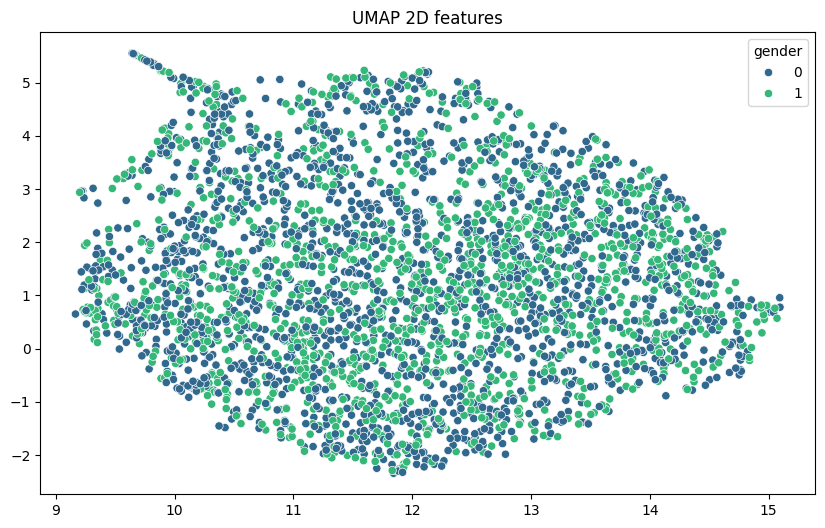

In [ ]:
show_2d_emb(reduced_embeddings, inf_test_df["gender"])

# Finaly, classification

In [ ]:
X = inf_test_df.drop(columns=["gender"])
y = inf_test_df["gender"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

In [ ]:
classifier = catboost.CatBoostClassifier(
    iterations = 150,
    random_seed = 42,
    verbose = 25,
    train_dir = "CatBoostClassifier",
)

In [ ]:
classifier.fit(
    X_train,
    y_train,
)

Learning rate set to 0.083675
0:	learn: 0.6848617	total: 124ms	remaining: 18.5s
25:	learn: 0.5748716	total: 2.31s	remaining: 11s
50:	learn: 0.5116336	total: 4.48s	remaining: 8.71s
75:	learn: 0.4588820	total: 5.86s	remaining: 5.71s
100:	learn: 0.4094169	total: 7.21s	remaining: 3.5s
125:	learn: 0.3566565	total: 8.55s	remaining: 1.63s
149:	learn: 0.3094623	total: 9.84s	remaining: 0us


In [ ]:
classifier.score(X_test, y_test)

0.6274111675126903

**We predicted it well enough!**